# Init

In [33]:
# List of tickers for Korean stocks
tickers = {
    "삼성전자": "005930", "SK": "034730", "한화": "000880",
    "두산": "000150", "기아": "000270", "현대차": "005380",
    "LG": "003550", "NAVER": "035420", "카카오": "035720", "롯데지주": "004990"
}

# Date range for the stock data
start_date = "20200101"
end_date = "20250101"

In [34]:
# Target ticker for analysis
TARGET_TICKER = "삼성전자"
ticker_code = tickers[TARGET_TICKER]

In [35]:
import numpy as np

# Set random seeds for reproducibility
np.random.seed(42)

### Load datasets

In [36]:
# Load the train, val, and test sets (list of DataFrames) from parquet files
import os
import json
import pandas as pd

dataset_dir = f"{ticker_code}_dataset"
train = []
val = []
test = []

if os.path.exists(dataset_dir):
    print(f"Loading dataset from {dataset_dir}/ directory...")
    
    # Load metadata
    with open(f"{dataset_dir}/metadata.json", 'r') as f:
        metadata = json.load(f)
    
    SEQ_LENGTH = metadata["seq_length"]
    print(f"Sequence length: {SEQ_LENGTH}")
    print(f"Ticker: {metadata['target_ticker']} ({metadata['ticker_code']})")
    assert SEQ_LENGTH > 0, "Sequence length must be greater than 0"
    assert ticker_code == metadata['ticker_code'], "Ticker code mismatch in metadata"
    assert TARGET_TICKER == metadata['target_ticker'], "Target ticker mismatch in metadata"
    
    # Load and reconstruct train set
    train_combined = pd.read_parquet(f"{dataset_dir}/train.parquet")
    for window_id in range(metadata["train_windows"]):
        window_df = train_combined[train_combined['window_id'] == window_id].drop('window_id', axis=1).reset_index(drop=True)
        train.append(window_df)
    
    # Load and reconstruct validation set
    val_combined = pd.read_parquet(f"{dataset_dir}/val.parquet")
    for window_id in range(metadata["val_windows"]):
        window_df = val_combined[val_combined['window_id'] == window_id].drop('window_id', axis=1).reset_index(drop=True)
        val.append(window_df)
    
    # Load and reconstruct test set
    test_combined = pd.read_parquet(f"{dataset_dir}/test.parquet")
    for window_id in range(metadata["test_windows"]):
        window_df = test_combined[test_combined['window_id'] == window_id].drop('window_id', axis=1).reset_index(drop=True)
        test.append(window_df)
    
    print(f"Loaded - Train windows: {len(train)}, Val windows: {len(val)}, Test windows: {len(test)}")
    print("Dataset loaded successfully!")
else:
    print(f"Dataset directory {dataset_dir} not found. Please run the dataset creation cells first.")


Loading dataset from 005930_dataset/ directory...
Sequence length: 20
Ticker: 삼성전자 (005930)
Loaded - Train windows: 716, Val windows: 226, Test windows: 226
Dataset loaded successfully!


### Create dataset loader

In [37]:
to_remove_columns = ['date', 'target']

In [38]:
def create_xy(dataset):
    xs, ys = [], []
    for df in dataset:
        x = df.drop(columns=to_remove_columns).values
        # Flatten x
        x = x.flatten()
        y = df['target'].iloc[-1]
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

# Create xy datasets
train_x, train_y = create_xy(train + val)
test_x, test_y = create_xy(test)

In [39]:
import xgboost as xgb

print("\n--- Training XGBoost model ---")
model = xgb.XGBRegressor()
model.fit(train_x, train_y)
print("\n--- Model training completed ---")


--- Training XGBoost model ---

--- Model training completed ---


## Evaluation

In [40]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
)

print("\n--- Model evaluation ---")
y_pred = model.predict(test_x)
mae = mean_absolute_error(test_y, y_pred)
mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")


--- Model evaluation ---
MAE: 0.0276, MSE: 0.0014, RMSE: 0.0370


In [41]:
# 1. Calculate the mean of the new training target (5-day avg returns)
train_y_mean = train_y.mean()
print(f"Mean of new training target: {train_y_mean:.6f}")

# 2. Create naive predictions for the test set
naive_preds = np.full(shape=test_y.shape, fill_value=train_y_mean)

# 3. Calculate RMSE for the new naive model
naive_mse = mean_squared_error(test_y, naive_preds)
naive_rmse = np.sqrt(naive_mse)

print(f"\n--- New Naive Baseline Model Metrics ---")
print(f"New Naive Model RMSE: {naive_rmse:.6f}")
print(f"Your Current Model Test RMSE: 0.0264")

improvement = (naive_rmse - 0.0264) / naive_rmse * 100

if naive_rmse <= 0.0264:
    print(f"\n🚨 경고: 모델이 여전히 단순 평균 예측보다 성능이 낮거나 비슷합니다. 다음 단계는 피처 엔지니어링입니다.")
else:
    print(f"\n✅ 성공! 모델이 드디어 베이스라인보다 약 {improvement:.2f}% 더 나은 성능을 보입니다!")
    print("이제 모델 튜닝 및 고도화를 진행할 차례입니다.")

Mean of new training target: 0.000701

--- New Naive Baseline Model Metrics ---
New Naive Model RMSE: 0.026055
Your Current Model Test RMSE: 0.0264

🚨 경고: 모델이 여전히 단순 평균 예측보다 성능이 낮거나 비슷합니다. 다음 단계는 피처 엔지니어링입니다.


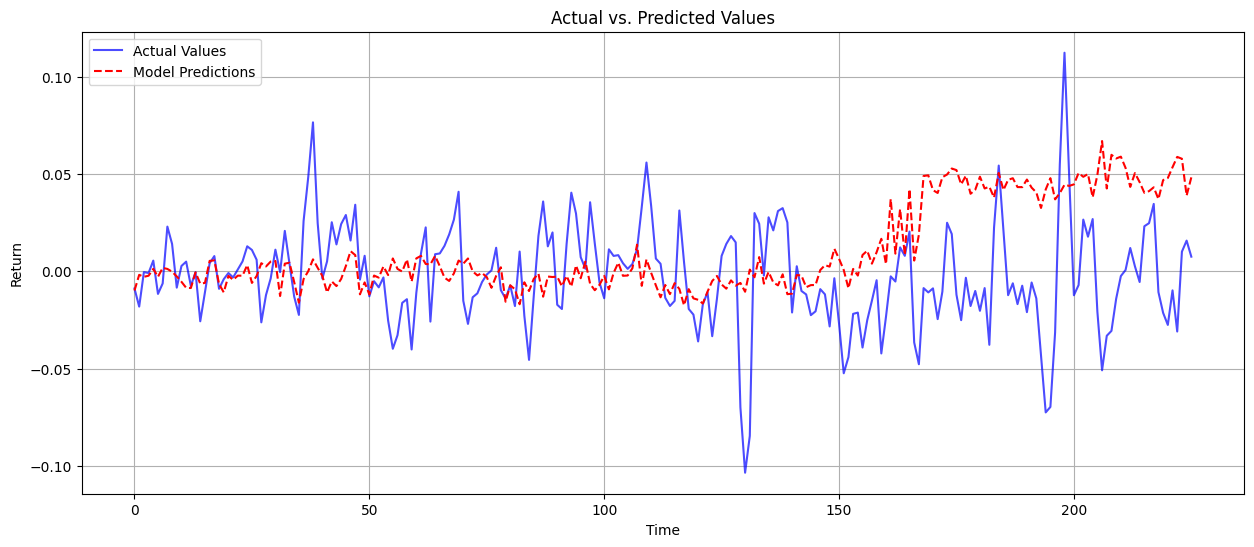

In [44]:
import matplotlib.pyplot as plt

# test_loader로 실제값과 예측값 가져오기
predictions = model.predict(test_x)
true_values = test_y

# 시각화
plt.figure(figsize=(15, 6))
plt.plot(true_values, label='Actual Values', color='blue', alpha=0.7)
plt.plot(predictions, label='Model Predictions', color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.savefig('prediction_vs_actual.png')
plt.show()

## Analyze Features

In [10]:
# --- Feature importance extraction and sorting ---
feature_importances = pd.DataFrame({
    'feature': list(train[0].drop(columns=to_remove_columns).columns)*20,
    'importance': model.feature_importances_
})

In [11]:
# Sort features by importance
sorted_features = feature_importances.sort_values(by='importance', ascending=False)

# https://github.com/bukosabino/ta/issues/181
# data leakage issue
# remove `volume_vpt, trend_vortex_ind_pos, trend_vortex_ind_neg, trend_vortex_ind_diff, trend_trix, trend_dpo, trend_kst, trend_kst_sig, trend_kst_diff, trend_visual_ichimoku_a, trend_visual_ichimoku_b, others_dr`
# + 'trend_ichimoku_base, trend_ichimoku_b' from the list
sorted_features = sorted_features[~sorted_features['feature'].isin([
    'volume_vpt', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
    'trend_vortex_ind_diff', 'trend_trix', 'trend_dpo', 'trend_kst',
    'trend_kst_sig', 'trend_kst_diff', 'trend_visual_ichimoku_a',
    'trend_visual_ichimoku_b', 'others_dr', 'trend_ichimoku_base',
    "trend_ichimoku_b"
])]
sorted_features = sorted_features.drop_duplicates(subset='feature').reset_index(drop=True)

print("\n--- Feature importance (Top 30) ---")
print(sorted_features.head(30))


--- Feature importance (Top 30) ---
          feature  importance
0             obv    0.010150
1            macd    0.009007
2     kospi_close    0.008042
3           close    0.007181
4     macd_signal    0.006990
5   exchange_rate    0.005945
6        bb_lband    0.005239
7        bb_hband    0.005088
8        bb_pband    0.004821
9             rsi    0.004792
10   us_10y_yield    0.004690
11      sentiment    0.004122


In [13]:
# --- Select top N features based on importance ---
top_n = 10
top_features = sorted_features['feature'].head(top_n).tolist()

print(f"\n--- Selected top {top_n} features ---")
for feature in top_features:
    print(feature)


--- Selected top 10 features ---
obv
macd
kospi_close
close
macd_signal
exchange_rate
bb_lband
bb_hband
bb_pband
rsi


In [14]:
# view columns with top features
print("\n--- Example data with top features ---")
df_top_features = train[0][['target_label'] + top_features]
df_top_features


--- Example data with top features ---


,target_label,obv,macd,kospi_close,close,macd_signal,exchange_rate,bb_lband,bb_hband,bb_pband,rsi
0,1,-1.376433,-0.035837,-1.050058,-1.043166,-0.038676,-0.577776,-0.738640,-1.335386,-1.466564,3.769013
1,1,-1.314661,-0.016811,-1.047012,-1.016208,-0.034665,-0.489437,-0.752093,-1.295091,0.805218,3.769013
2,1,-1.273490,-0.002121,-1.097516,-1.016208,-0.028361,-0.460726,-0.746070,-1.292151,0.583422,3.769013
3,2,-1.233398,0.028030,-1.049185,-0.989250,-0.016962,-0.476431,-0.749785,-1.270533,1.118886,3.769013
4,2,-1.139267,0.114346,-1.106394,-0.899389,0.010350,-0.422446,-0.787706,-1.186112,1.470727,3.769013
5,2,-1.042728,0.294418,-1.023425,-0.737639,0.070154,-0.569433,-0.856343,-1.032820,1.576028,3.769013
6,1,-0.978642,0.488815,-0.976345,-0.656764,0.158972,-0.538146,-0.886916,-0.918723,1.392820,3.769013
7,1,-0.933144,0.666852,-0.922347,-0.611834,0.267552,-0.598634,-0.896213,-0.835569,1.239760,3.769013
8,0,-0.865429,0.798332,-0.899633,-0.611834,0.382129,-0.598266,-0.888721,-0.785592,1.042987,3.769013
9,2,-0.922709,0.828416,-0.918286,-0.701695,0.480132,-0.591395,-0.867214,-0.779007,0.606462,2.095489
